In [1]:
%matplotlib inline

import os
import time
import copy
import pandas as pd
import numpy as np

from random import seed
from random import randint
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from PIL import Image
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook as tqdm


#input_dir = os.path.join("k")
train_dir = os.path.join("/home/nitin/Desktop/imet -2019/imet-2019-fgvc6/train")
test_dir  = os.path.join("test")
labels_csv= os.path.join('labels.csv')
train_csv = os.path.join('train.csv')
resnet_weights_path = os.path.join('/home/nitin/Desktop/imet -2019/resnet50.pth')

In [2]:
df = pd.read_csv(labels_csv)
attribute_dict = dict(zip(df.attribute_id,df.attribute_name))
del df,labels_csv

In [3]:
tag_count = 0 
culture_count = 0
for idx,data in attribute_dict.items():
    if data.split("::")[0] == 'tag':
        tag_count+=1
    if data.split("::")[0] == 'culture':
        culture_count+=1
print('total_categories: {0}\ntag_categories: {1} \nculture_categories: {2} ' \
      .format(len(attribute_dict),tag_count,culture_count))
#cross check your results
assert tag_count+culture_count == len(attribute_dict)
output_dim = len(attribute_dict) 

total_categories: 1103
tag_categories: 705 
culture_categories: 398 


In [4]:
df = pd.read_csv(train_csv)
labels_dict = dict(zip(df.id,df.attribute_ids))

culture::inca
tag::birds
tag::bottles


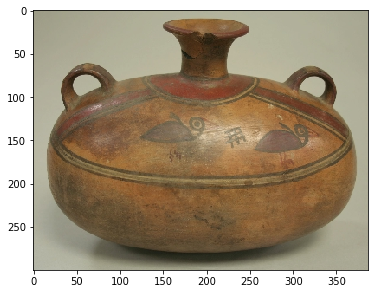

In [5]:
idx = len(os.listdir(train_dir))
number = randint(0,idx)
image_name = os.listdir(train_dir)[number]
def imshow(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.show()
# Example image
x = Image.open(os.path.join(train_dir,image_name))
for i in labels_dict[os.listdir(train_dir)[number].split('.')[0]].split():
    print(attribute_dict[int(i)])
np.array(x).shape
imshow(x)

In [6]:
BATCH_SIZE = 1
NUM_EPOCHS = 1
PERCENTILE = 99.7
LEARNING_RATE = 0.1
DISABLE_TQDM = True

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# need to add more transforms here
data_transforms = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
    ])

In [9]:
from torch.utils import data
class ImageData(data.Dataset):
    def __init__(self,df,dirpath,transform,test = False):
        self.df = df
        self.test = test
        self.dirpath = dirpath
        self.conv_to_tensor = transform
        #image data 
        if not self.test:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
        else:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
        #labels data
        if not self.test:
             self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        image_name = self.image_arr[idx]
        img = Image.open(image_name)
        img_tensor = self.conv_to_tensor(img)
        if not self.test:
            image_labels = self.label_df[idx]
            label_tensor = torch.zeros((1, output_dim))
            for label in image_labels.split():
                label_tensor[0, int(label)] = 1
            image_label = torch.tensor(label_tensor,dtype= torch.float32)
            return (img_tensor,image_label.squeeze())
        return (img_tensor)

In [10]:
#df = pd.read_csv(train_csv)
# if you want to run on less data to quickly check
df = pd.read_csv(train_csv).head(500)
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(df, test_size=0.20)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Validation_Data Length: {len(val_df)}\n Train_Data Length: {len(train_df)}")

Validation_Data Length: 100
 Train_Data Length: 400


In [11]:
# Train dataset
train_dataset = ImageData(train_df,train_dir,data_transforms)
train_loader = data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=False)

# validation dataset
val_dataset = ImageData(val_df,train_dir,data_transforms)
val_loader = data.DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle=False)

# test dataset
test_df = pd.DataFrame(os.listdir(test_dir))
test_dataset = ImageData(test_df,test_dir,data_transforms,test = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

dataloaders_dict = {'train':train_loader, 'val':val_loader}

In [12]:
features, labels = next(iter(train_loader))
print(f'Train Features: {features.shape}\nTrain Labels: {labels.shape}')
print()
features, labels = next(iter(val_loader))
print(f'Validation Features: {features.shape}\nValidation Labels: {labels.shape}')
print()
features = next(iter(test_loader))
print(f'Test Features: {features.shape}\n')

Train Features: torch.Size([1, 3, 32, 32])
Train Labels: torch.Size([1, 1103])

Validation Features: torch.Size([1, 3, 32, 32])
Validation Labels: torch.Size([1, 1103])

Test Features: torch.Size([1, 3, 32, 32])



In [13]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))

        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

In [14]:
class bottleNeck(torch.nn.Module):
    expansion = 4
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(bottleNeck,self).__init__()

        self.conv1 = torch.nn.Conv2d(input_planes,planes,kernel_size=1,stride=1)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.conv3 = torch.nn.Conv2d(planes,planes*self.expansion,kernel_size=1)
        self.bn3 = torch.nn.BatchNorm2d(planes*self.expansion)
        self.dim_change = dim_change
    
    def forward(self,x):
        res = x
        
        output = F.relu(self.bn1(self.conv1(x)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)
        return output

In [15]:
class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=1103):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64
        self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(64)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,128,num_layers[1],stride=2)
        self.layer3 = self._layer(block,256,num_layers[2],stride=2)
        self.layer4 = self._layer(block,512,num_layers[3],stride=2)
        self.averagePool = torch.nn.AvgPool2d(kernel_size=4,stride=1)
        self.fc    =  torch.nn.Linear(512*block.expansion,classes)
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.avg_pool2d(x,4)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x

In [16]:
NeuralNet  =  ResNet(bottleNeck,[3,4,6,3])
NeuralNet.to(device)
    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): bottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dim_change): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): bottleNeck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))

In [17]:
NeuralNet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): bottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dim_change): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): bottleNeck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))

In [18]:
total_params = sum(p.numel() for p in NeuralNet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in NeuralNet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

25,786,959 total parameters.
25,786,959 training parameters.


In [19]:
print("TRAINING")
print("training examples: ",len(train_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(train_loader))
print()
print("TESTING")
print("validation examples: ",len(val_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(val_loader))
print()
print("VALIDATION")
print("testing examples: ",len(test_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(test_loader))

TRAINING
training examples:  400
batch size:  1
batches available:  400

TESTING
validation examples:  100
batch size:  1
batches available:  100

VALIDATION
testing examples:  90
batch size:  1
batches available:  90


In [20]:
NeuralNet = NeuralNet.to(device)
optimizer = optim.Adam(NeuralNet.parameters(),lr = LEARNING_RATE)
loss_func = torch.nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 2)
best_loss = np.inf
for epoch in range(NUM_EPOCHS):
    for phase in ['train', 'val']:
        start_time = time.time()
        if phase == 'train':
            NeuralNet.train()
        else:
            NeuralNet.eval()
            
        running_loss = 0.0
        for images_batch, labels_batch in tqdm(dataloaders_dict[phase],disable = DISABLE_TQDM):
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                pred_batch = NeuralNet(images_batch)
                loss = loss_func(pred_batch,labels_batch)
                
            if phase == 'train':
                loss.backward()
                optimizer.step()
                
            running_loss += loss.item() * images_batch.size(0)    
        epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)            

        if phase == 'val' and epoch_loss < best_loss:            
            print("model val_loss Improved from {:.8f} to {:.8f}".format(best_loss,epoch_loss))
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(NeuralNet.state_dict())
        
        if phase == 'val':
            scheduler.step(epoch_loss)
        
        elapsed_time = time.time()-start_time
        print("Phase: {} | Epoch: {}/{} | {}_loss:{:.8f} | Time: {:.4f}s".format(phase,
                                                                              epoch+1,
                                                                              NUM_EPOCHS,
                                                                              phase,
                                                                              epoch_loss,
                                                                              elapsed_time))
NeuralNet.load_state_dict(best_model_wts)

Phase: train | Epoch: 1/1 | train_loss:0.02936633 | Time: 265.1340s
model val_loss Improved from inf to 12.03890058
Phase: val | Epoch: 1/1 | val_loss:12.03890058 | Time: 9.2205s


<All keys matched successfully>

In [21]:
NeuralNet.eval()
predictions = np.zeros((len(test_dataset), output_dim))
i = 0
for test_batch in tqdm(test_loader,disable = DISABLE_TQDM):
    test_batch = test_batch.to(device)
    batch_prediction = NeuralNet(test_batch).detach().cpu().numpy()
    predictions[i * BATCH_SIZE:(i+1) * BATCH_SIZE, :] = batch_prediction
    i+=1

In [22]:
predicted_class_idx = []
for i in range(len(predictions)):         
    idx_list = np.where(predictions[i] > np.percentile(predictions[i],PERCENTILE))    
    predicted_class_idx.append(idx_list[0])

In [23]:
test_df['attribute_ids'] = predicted_class_idx
test_df['attribute_ids'] = test_df['attribute_ids'].apply(lambda x : ' '.join(map(str,list(x))))
test_df = test_df.rename(columns={0: 'id'})
test_df['id'] = test_df['id'].apply(lambda x : x.split('.')[0])
test_df.head()

,id,attribute_ids
0,1a79d203d79c5163,13 189 501 733
1,1a204d327a6475e4,13 189 501 733
2,1a393da6135eb1a8,13 189 501 733
3,1a294d9a33fba200,13 189 501 733
4,1a004e0662ac9844,13 189 501 733


In [24]:
test_df.to_csv('submission.csv',index = False)